## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.impute import SimpleImputer

from sklearn.datasets import fetch_openml
from imblearn.datasets import make_imbalance

from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import sklearn
sklearn.set_config(display = 'diagram')

In [2]:
ckd = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
ckd.shape

(400, 25)

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

1) age

2) blood pressure

3) albumin

4) age and blood pressure together

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [4]:
ckd.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [5]:
ckd['class'].value_counts(normalize = True)

ckd       0.625
notckd    0.375
Name: class, dtype: float64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [6]:
ckd_dropped = ckd.dropna()
ckd_dropped.shape

(158, 25)

Only 158 out of 400 original rows remain.

Two downsides:

1) Reduces statistical power because it lowers our count of cases.

2) Estimates may be biased because if the null values are all from a similar group of people, we'd miss out on a lot of important data.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

1) Pus Cell is measure as normal or abnormal - this could be up to interpretation.

2) Pus Cell clumps is also measure as normal or abnormal - this could be up to interpretation.

3) Even for the numerical features, if each measure is taken by a different doctor/nurse, there could be some variation on how or when the tests are performed for each person.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

Our null model would tell us this, which is to guess CKD every single time. You would be 62.5% accurate.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Sensitivity. We minimized false negatives.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

This would put a lot of people under stress thinking they have CKD when they don't. It is taking the (extremely) easy way out instead of correctly diagnosing the patient.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

We could guess 100% of the time that no one has CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Specificity. We minimized false positives.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

People who have CKD will never know! Assuming no one has it would put everyone at risk.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

Remember to do a train/test split. We suggest using GridSearchCV and pipelines.

In [7]:
ckd.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [8]:
ckd = ckd[ckd['dm'].isnull() == False]

In [9]:
ckd.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        0
dm         0
cad        0
appet      1
pe         1
ane        1
class      0
dtype: int64

In [10]:
ckd['class'] = np.where(ckd['class'] == 'ckd', 1, 0)

In [11]:
X = ckd[['age', 'bp', 'al', 'dm']]
y = ckd['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8, stratify = y)

In [13]:
pipe = make_pipeline(OneHotEncoder(use_cat_names = True),
                     SimpleImputer(strategy = 'mean'),
                     StandardScaler(),
                     LogisticRegression(max_iter = 1000))

In [14]:
gs = GridSearchCV(pipe, 
                  {'logisticregression__C': [.1, 1, 10],
                  })

In [15]:
gs.fit(X_train, y_train)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\categor

GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.1, 1, 10]})

In [16]:
gs.best_params_

{'logisticregression__C': 1}

In [17]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.061384,0.010809,0.007062,0.007146,0.1,{'logisticregression__C': 0.1},0.850000,0.916667,0.900000,0.915254,0.966102,0.909605,0.037199,3
1,0.048228,0.008534,0.010155,0.003880,1,{'logisticregression__C': 1},0.883333,0.916667,0.883333,0.915254,0.966102,0.912938,0.030327,1
2,0.040622,0.007657,0.006250,0.007655,10,{'logisticregression__C': 10},0.883333,0.916667,0.883333,0.915254,0.966102,0.912938,0.030327,1


In [18]:
pipe = make_pipeline(OneHotEncoder(use_cat_names = True),
                     SimpleImputer(strategy = 'mean'),
                     StandardScaler(),
                     LogisticRegression(max_iter = 1000))

In [19]:
pipe.fit(X_train, y_train)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['dm'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [20]:
pipe.score(X_train, y_train)

0.9161073825503355

In [21]:
pipe.score(X_test, y_test)

0.94

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [22]:
features = pipe['onehotencoder'].get_feature_names()

In [23]:
coefs = pipe['logisticregression'].coef_

In [24]:
pd.DataFrame({'features': features, 'coefs': coefs[0]})

,features,coefs
0,age,0.028729
1,bp,0.600959
2,al,2.991061
3,dm_no,-1.153674
4,dm_yes,1.153674


Blood pressure is positively correlated with having CKD. There is a higher probability of CKD. The higher your blood pressure, the higher your changes of having CKD are.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

If the patient has Diabetes Mellitus they are more likely to have CKD because the coefficient for dm_yes is positive, moving the probability closer to CKD.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

1) Logistic Regression allows us to see coefficients, which helps us understand the direction the feature moves the probability.

2) We can also predict the probability with the predict_proba function.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

It makes more sense to generate a confusion matrix on our test data because it will tell us how good our model is performing on new samples it has never seen before.

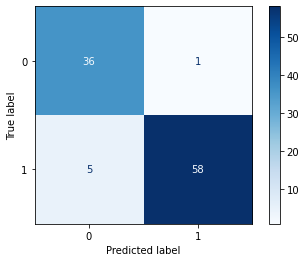

In [25]:
plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Blues')

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

In a hospital case, we should optimize for sensitivity. It's much worse to tell someone they don't have CKD when they actually do.

### 18. Plot the ROC Curve.

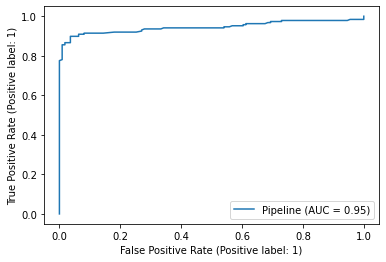

In [26]:
plot_roc_curve(pipe, X_train, y_train)

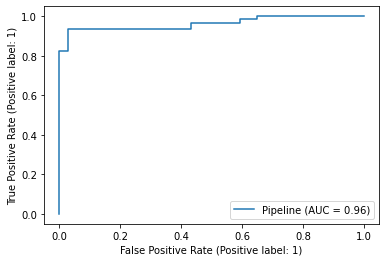

In [27]:
plot_roc_curve(pipe, X_test, y_test)

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

We'll leave that for another day!